In [11]:
import signac

project = signac.get_project()

import itertools
import math

import gsd.hoomd
import hoomd
import numpy as np
from hoomd import hpmc, md
from matplotlib import pyplot as plt
from scipy.stats.qmc import Sobol

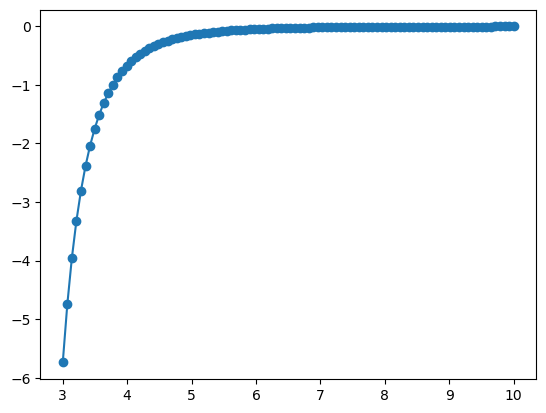

In [22]:
a1 = 1
a2 = 1
A = 1000
kappa = 1
Z = 0

def dlvo(r):
    return (-1)*(A/6)*((2*a1*a2)/(r**2-(a1+a2)**2)+(2*a1*a2)/(r**2-(a1-a2)**2)+np.log((r**2-(a1+a2)**2)/(r**2-(a1-a2)**2)))+((a1*a2)/(a1+a2))*Z*np.exp(-1*kappa*(r-(a1+a2)))

rs = np.linspace(1.5*(a1+a2), 10*a1, 100)
plt.plot(rs, dlvo(rs), marker='o')


In [13]:
r = 3.25
dlvo(r)

-3.0287754037316796

In [28]:
device = hoomd.device.CPU()
sim = hoomd.Simulation(device=device)
sim.seed = 0

N_particles = 20
L = 20
rcut = L * 0.4
s = Sobol(3)
position = np.array([L * (s.random()-0.5).flatten() for _ in range(N_particles)])

snapshot = gsd.hoomd.Frame()
snapshot.particles.N = N_particles
snapshot.particles.types = ["A"]
snapshot.particles.position = position[0:N_particles]
snapshot.configuration.box = [L, L, L, 0, 0, 0]

sim.create_state_from_snapshot(snapshot)

with gsd.hoomd.open(name="lattice.gsd", mode="w") as f:
    f.append(snapshot)

nlist = md.nlist.Cell(buffer=0.5)
dlvo = md.pair.DLVO(nlist=nlist, default_r_cut=rcut*a1)
dlvo.params["A", "A"] = dict(A=A, kappa=kappa, Z=Z, a1=a1, a2=a2)

In [29]:
position

array([[ 1.02658864,  7.70347739,  4.15308183],
       [-6.43564636, -2.18276802, -1.77204376],
       [-3.40439612,  4.03601781,  9.81078207],
       [ 9.12604567, -5.84091971, -7.35032443],
       [ 5.53860383,  1.76488925, -4.67233866],
       [-2.00419687, -8.74925597,  1.89701345],
       [-7.52580546,  5.59716282, -9.02022446],
       [ 4.92895203, -4.90675904,  6.32417107],
       [ 3.08213172,  3.49048933, -8.62293854],
       [-9.38971635, -6.7013897 ,  6.08210396],
       [-0.13791796,  9.81395092, -3.03849706],
       [ 7.38291083, -0.38723594,  0.4208369 ],
       [ 8.49260107,  6.92392819,  7.55650183],
       [-4.05981263, -2.64005216, -5.2537044 ],
       [-5.7827433 ,  0.74819075,  3.12562481],
       [ 1.66240111, -8.82601302, -0.89981038],
       [ 1.97743975,  0.3381991 ,  5.09480987],
       [-5.47243504, -9.78471076, -7.71022774],
       [-4.99993114,  6.67230358,  0.74631365],
       [ 7.55751811, -3.44160363, -3.2849011 ]])

In [30]:
from scipy.spatial.distance import cdist
cdist(position, position)

array([[ 0.        , 13.73061953,  8.06805167, 19.52895932, 11.55478936,
        16.88099346, 15.84664016, 13.37759811, 13.60886558, 17.88073633,
         7.58478616, 10.94495893,  8.24210569, 14.87775885,  9.78768009,
        17.29624324,  7.48587294, 22.10909649,  6.99916634, 14.90602095],
       [13.73061953,  0.        , 13.4916133 , 16.93120042, 12.93747951,
         8.73032011, 10.68886777, 14.21699399, 13.02722948,  9.53058801,
        13.60832658, 14.10621082, 19.8193403 ,  4.23977068,  5.74490723,
        10.51055983, 11.14849639,  9.69429412,  9.31749405, 14.13089014],
       [ 8.06805167, 13.4916133 ,  0.        , 23.43223085, 17.17253794,
        15.10137468, 19.33985511, 12.71119213, 19.54928901, 12.84597286,
        14.46230843, 14.9700446 , 12.44830703, 16.49054983,  7.82033693,
        17.48774033,  8.0547138 , 22.411495  ,  9.57393976, 18.64337158],
       [19.52895932, 16.93120042, 23.43223085,  0.        ,  8.82551282,
        14.75987725, 20.27072875, 14.33457632, 1

In [31]:
kT = 1.0

sim.state.thermalize_particle_momenta(
    filter=hoomd.filter.All(),
    kT=kT)

# Integrate
integrator = md.Integrator(dt=0.0005)
integrator.forces.append(dlvo)

langevin = md.methods.Langevin(kT=kT, filter=hoomd.filter.All())
integrator.methods.append(langevin)
sim.operations.integrator = integrator

trigger = hoomd.trigger.Periodic(period=int(1))

# Log data
logger = hoomd.logging.Logger(categories=["scalar", "string"])
table = hoomd.write.Table(trigger=trigger, logger=logger)

# Create a ThermodynamicQuantities object for the simulation
thermo = hoomd.md.compute.ThermodynamicQuantities(filter=hoomd.filter.All())
sim.operations.computes.append(thermo)

# Add a log for the tracked variables
logger.add(thermo, quantities=['potential_energy','pressure','kinetic_temperature'])

In [32]:
# Save results to table
file = open("log.txt", mode="w", newline="\n")
table_file = hoomd.write.Table(
    output=file, trigger=trigger, logger=logger
)
sim.operations.writers.append(table_file)

gsd_writer = hoomd.write.GSD(filename='trajectory.gsd',
        trigger=trigger)

sim.operations.writers.append(gsd_writer)

# Run simulation
sim.run(1)